In [15]:
## Cell 1: Import Libraries and Setup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [16]:
## Cell 2: Get Stock Data and Explore
def get_stocks_data(symbols, start_date, end_date):
    """
    Get data for multiple stocks, however it rest of the code relies on a single stock's data structure.
    More testing & development to come for multi-stock support.
    """
    if isinstance(symbols, str):
        symbols = [symbols]  # Convert single string to list
    
    print(f"Getting data for {symbols} from {start_date} to {end_date}...")
    data = yf.download(symbols, start=start_date, end=end_date)
    print(f"Got {len(data)} days of data for {len(symbols)} stocks")
    
    # Flatten if only one stock to keep it simple
    if len(symbols) == 1:
        data = data.droplevel(1, axis=1)
    
    return data


In [ ]:
## Function 2: Define and Test Dip Buying Strategy
def dip_buying_strategy(data, daily_budget=10, dip_threshold=0.10):
    """
    Buy when stock drops by dip_threshold (default 10%) from recent peak
    Money accumulates daily until a dip occurs
    """
    cash = 0
    shares = 0
    transactions = []
    daily_values = []
    
    # Track the highest price seen so far (rolling peak)
    peak_price = data['Close'].iloc[0]
    
    print(f"Running Dip Buying Strategy:")
    print(f"- Daily budget: ${daily_budget}")
    print(f"- Dip threshold: {dip_threshold*100}%")
    print(f"- Starting peak price: ${peak_price:.2f}")
    print()
    
    for i, (date, row) in enumerate(data.iterrows()):
        current_price = row['Close']
        cash += daily_budget  # Add daily budget
        
        # Update peak price if current price is higher
        if current_price > peak_price:
            peak_price = current_price
        
        # Check if current price is below the dip threshold
        dip_price = peak_price * (1 - dip_threshold)
        
        if current_price <= dip_price and cash >= current_price:
            # Buy as many shares as possible with accumulated cash
            shares_to_buy = int(cash / current_price)
            if shares_to_buy > 0:
                cost = shares_to_buy * current_price
                cash -= cost
                shares += shares_to_buy
                
                dip_percent = ((peak_price - current_price) / peak_price) * 100
                
                transactions.append({
                    'Date': date,
                    'Price': current_price,
                    'Shares': shares_to_buy,
                    'Cost': cost,
                    'Peak': peak_price,
                    'Dip_Percent': dip_percent
                })
                
                print(f"{date.strftime('%Y-%m-%d')}: Bought {shares_to_buy} shares at ${current_price:.2f}")
                print(f"   -> {dip_percent:.1f}% dip from peak of ${peak_price:.2f}")
                print(f"   -> Spent ${cost:.2f}, Cash remaining: ${cash:.2f}")
                print()
                peak_price = current_price  # Reset peak price after purchase

        # Calculate total portfolio value
        portfolio_value = cash + (shares * current_price)
        daily_values.append(portfolio_value)
    
    total_invested = len(data) * daily_budget
    final_value = cash + (shares * data['Close'].iloc[-1])
    
    return {
        'daily_values': daily_values,
        'transactions': transactions,
        'final_value': final_value,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'shares': shares
    }


_______________________________________________________________________________________________________________________________________________________________________________________

# Testing Area

In [ ]:
# Test Function #2
# Test the dip buying strategy
daily_budget = 10  # $10 per day
dip_results = dip_buying_strategy(data, daily_budget=daily_budget, dip_threshold=0.05)

print("="*50)
print("="*50)
print("DIP BUYING STRATEGY RESULTS:")
print(f"Total money allocated: ${dip_results['total_invested']:,.2f}")
print(f"Final portfolio value: ${dip_results['final_value']:,.2f}")
print(f"Cash remaining: ${dip_results['cash_remaining']:.2f}")
print(f"Shares owned: {dip_results['shares']}")
print(f"Number of purchases: {len(dip_results['transactions'])}")

profit = dip_results['final_value'] - dip_results['total_invested']
profit_percent = (profit / dip_results['total_invested']) * 100
print(f"Profit: ${profit:,.2f} ({profit_percent:.1f}%)")


Running Dip Buying Strategy:
- Daily budget: $10
- Dip threshold: 5.0%
- Starting peak price: $216.77

2024-09-16: Bought 1 shares at $215.56
   -> 5.9% dip from peak of $228.99
   -> Spent $215.56, Cash remaining: $34.44

2024-11-01: Bought 1 shares at $222.13
   -> 5.7% dip from peak of $235.65
   -> Spent $222.13, Cash remaining: $152.31

2025-01-02: Bought 2 shares at $243.26
   -> 5.9% dip from peak of $258.40
   -> Spent $486.53, Cash remaining: $75.78

2025-02-03: Bought 1 shares at $227.46
   -> 6.9% dip from peak of $244.41
   -> Spent $227.46, Cash remaining: $48.32

2025-03-10: Bought 1 shares at $227.18
   -> 7.9% dip from peak of $246.78
   -> Spent $227.18, Cash remaining: $61.14

2025-04-03: Bought 1 shares at $202.92
   -> 10.7% dip from peak of $227.18
   -> Spent $202.92, Cash remaining: $38.21

2025-05-05: Bought 1 shares at $198.63
   -> 6.8% dip from peak of $213.04
   -> Spent $198.63, Cash remaining: $49.59

2025-05-28: Bought 1 shares at $200.42
   -> 5.9% dip f

In [17]:
# Testing Function 1
# Let's get Apple stock data for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
symbol = 'AAPL'

data = get_stocks_data(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

# Explore the data
print("\nFirst 5 rows of data:")
print(data.head())

print(f"\nStock price range:")
print(f"Lowest: ${data['Close'].min():.2f}")
print(f"Highest: ${data['Close'].max():.2f}")
print(f"Average: ${data['Close'].mean():.2f}")

C:\Users\lippm\AppData\Local\Temp\ipykernel_20104\3645528345.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Getting data for ['AAPL'] from 2024-08-10 to 2025-08-10...
Got 249 days of data for 1 stocks

First 5 rows of data:
Price            Close        High         Low        Open    Volume
Date                                                                
2024-08-12  216.768021  218.741081  214.844788  215.313143  38028100
2024-08-13  220.494949  221.112773  218.242856  218.242856  44155300
2024-08-14  220.943344  222.248753  218.930416  219.797379  41960600
2024-08-15  223.932846  224.560644  221.979705  223.813271  46414000
2024-08-16  225.258194  226.035461  222.866592  223.135650  44340200

Stock price range:
Lowest: $172.19
Highest: $258.40
Average: $221.60


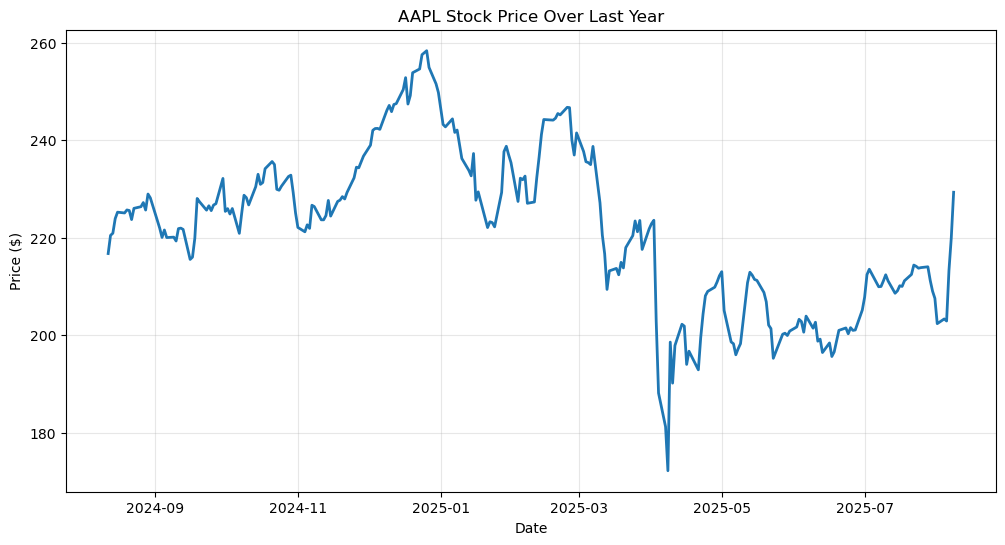

We'll be testing strategies on this 249-day period


In [18]:
## Plotting Function 1: Plot Stock Price to See What We're Working With
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], linewidth=2)
plt.title(f'{symbol} Stock Price Over Last Year')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"We'll be testing strategies on this {len(data)}-day period")


In [22]:
print(type(dip_results['daily_values']))

<class 'list'>
